<a href="https://colab.research.google.com/github/nisal2002/Activity-Club-Management-System/blob/nisal/%20v3%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import os
import cv2
from tqdm import tqdm
from tqdm import tqdm_notebook

In [3]:
# Assuming the 'train' directory is in the 'fruit-dta' directory on Google Drive
train_dir = '/content/drive/MyDrive/ColabNotebooks/fruit-dta/train/mango'

In [4]:
# Assuming there are three classes: 'unripe', 'partially ripe', 'ripe'
classes = ['0 un ripe', '1 partially ripe', '2 ripe']

X = []
y = []

for class_label, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    for img_name in tqdm(os.listdir(class_path)):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (244, 244))
        X.append(img)
        y.append(class_label)

100%|██████████| 274/274 [00:05<00:00, 47.16it/s]


In [5]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
import numpy as np

# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

In [7]:
# Print shapes
print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)

X_train Shape:  (375, 244, 244, 3)
X_test Shape:  (186, 244, 244, 3)
y_train Shape:  (375,)
y_test Shape:  (186,)


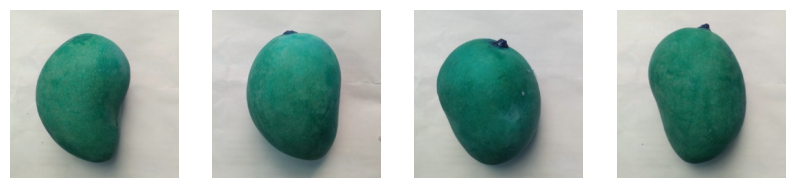

In [8]:
# Visualization (optional)
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()

In [9]:
# Model Building (continuation)
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras import regularizers

img_rows, img_cols = 244, 244

In [10]:
# Load InceptionV3 model with pre-trained weights
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [11]:
# Freeze the layers
for layer in inception.layers:
    layer.trainable = False

In [12]:
# Custom head
def custom_head(bottom_model, num_classes):
    top_model = bottom_model.output
    top_model = GlobalAveragePooling2D()(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(512, activation='relu')(top_model)
    top_model = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
    top_model = Dropout(0.5)(top_model)  # Add dropout for regularization
    top_model = Dense(num_classes, activation='softmax')(top_model)
    return top_model

In [13]:
# Add custom head on top of InceptionV3
num_classes = len(classes)
FC_Head = custom_head(inception, num_classes)
model = Model(inputs=inception.input, outputs=FC_Head)


In [14]:
# Model summary
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 244, 244, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 121, 121, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 121, 121, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
# Model compilation
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Model Training
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_test, y_test), verbose=1, initial_epoch=0)

Epoch 1/30
12/12 [==============================] - 89s 7s/step - loss: 23.7241 - accuracy: 0.3973 - val_loss: 6.7881 - val_accuracy: 0.6344
Epoch 2/30
12/12 [==============================] - 85s 7s/step - loss: 5.4447 - accuracy: 0.5787 - val_loss: 2.1543 - val_accuracy: 0.7473
Epoch 3/30
12/12 [==============================] - 98s 8s/step - loss: 2.5396 - accuracy: 0.5813 - val_loss: 1.8795 - val_accuracy: 0.7312
Epoch 4/30
12/12 [==============================] - 103s 9s/step - loss: 2.0123 - accuracy: 0.5707 - val_loss: 1.9849 - val_accuracy: 0.6344
Epoch 5/30
12/12 [==============================] - 85s 7s/step - loss: 1.9563 - accuracy: 0.5867 - val_loss: 1.6886 - val_accuracy: 0.7312
Epoch 6/30
12/12 [==============================] - 98s 8s/step - loss: 1.8761 - accuracy: 0.5493 - val_loss: 1.6245 - val_accuracy: 0.7419
Epoch 7/30
12/12 [==============================] - 98s 8s/step - loss: 1.8149 - accuracy: 0.5893 - val_loss: 1.7311 - val_accuracy: 0.5860
Epoch 8/30
12/12 [

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"\nTest Accuracy: {test_accuracy * 100:.2f}%")


6/6 [==============================] - 30s 4s/step - loss: 1.1567 - accuracy: 0.7634

Test Accuracy: 76.34%


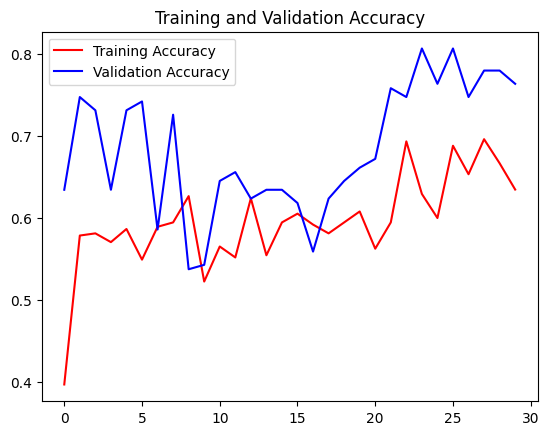

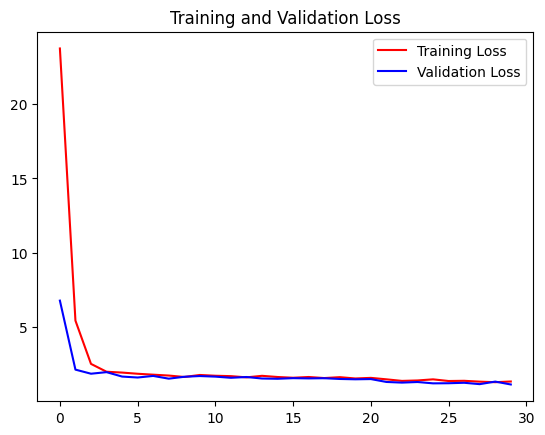

In [21]:
# Visualization of Training History
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()